In [1]:
%load_ext autoreload
%autoreload all

import torch

from gem import MiniFranceDataset
from torch.utils.data import DataLoader, random_split

n_tiles = 4 
dir_path = '/GEM/data/MiniFrance/'
dataset = MiniFranceDataset(dir_path, n_tiles=n_tiles, dataset_type='labeled_train')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True, num_workers=1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


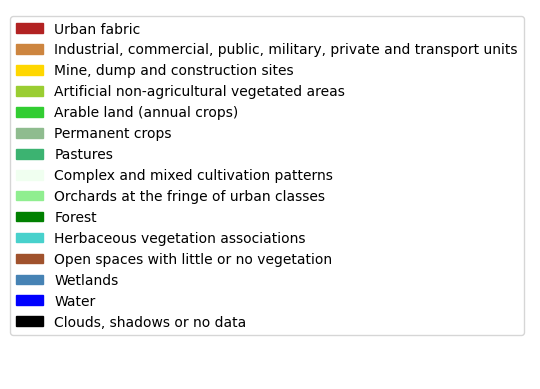

In [2]:
from typing import Any
import matplotlib.colors as mcolors

class_attributes: list[tuple[str, Any]] = [
    ("Urban fabric", mcolors.CSS4_COLORS['firebrick']),
    ('Industrial, commercial, public, military, private and transport units', mcolors.CSS4_COLORS['peru']),
    ("Mine, dump and construction sites", mcolors.CSS4_COLORS['gold']),
    ("Artificial non-agricultural vegetated areas", mcolors.CSS4_COLORS['yellowgreen']),
    ("Arable land (annual crops)", mcolors.CSS4_COLORS['limegreen']),
    ("Permanent crops", mcolors.CSS4_COLORS['darkseagreen']),
    ("Pastures", mcolors.CSS4_COLORS['mediumseagreen']),
    ("Complex and mixed cultivation patterns", mcolors.CSS4_COLORS['honeydew']),
    ("Orchards at the fringe of urban classes", mcolors.CSS4_COLORS['lightgreen']),
    ("Forest", mcolors.CSS4_COLORS['green']),
    ("Herbaceous vegetation associations", mcolors.CSS4_COLORS['mediumturquoise']),
    ("Open spaces with little or no vegetation", mcolors.CSS4_COLORS['sienna']),
    ('Wetlands', mcolors.CSS4_COLORS['steelblue']),
    ("Water", mcolors.CSS4_COLORS['blue']),
    ("Clouds, shadows or no data", mcolors.CSS4_COLORS['black']),
]

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in class_attributes]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [3]:
from gem.model import SegNet
from torch.nn.functional import one_hot
from tqdm import tqdm

tile_size = dataset.get_tile_size()
model = SegNet(features=64, out_channels=len(class_attributes))
model.to(device)

def train_one_epoch(optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.

    pbar = tqdm(total=len(train_loader))
    for i, data in enumerate(train_loader):
        images = [image for image in data['image']]
        landcover_maps = [image for image in data['landcover_map']]

        inputs = torch.stack(images).float().to(device)

        labels = torch.stack(landcover_maps).to(device)
        unique_labels = torch.unique(labels.view(-1))
        if not unique_labels.ge(0).all() or not unique_labels.lt(len(class_attributes)).all():
            print("Invalid class indices in labels")
            print(unique_labels)
            continue
        labels = one_hot(labels.long(), num_classes=len(class_attributes))
        labels = labels.squeeze(1).permute(0, 3, 1, 2).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        pbar.update(1)

        print_step = 100
        if i % print_step == print_step - 1:
            last_loss = running_loss / print_step # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.0

    return last_loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

model.train(True)
train_one_epoch(optimizer, loss_fn)

64 3 15


  2%|▏         | 100/4902 [00:49<38:14,  2.09it/s]

  batch 100 loss: 2.1662400662899017


  4%|▍         | 200/4902 [01:37<37:25,  2.09it/s]

  batch 200 loss: 1.9742127406597136


  6%|▌         | 300/4902 [02:24<36:46,  2.09it/s]

  batch 300 loss: 2.0835842072963713


  8%|▊         | 400/4902 [03:12<35:47,  2.10it/s]

  batch 400 loss: 2.1019034135341643


 10%|▉         | 466/4902 [03:44<35:19,  2.09it/s]

Invalid class indices in labels
tensor([ 1,  2,  5,  7, 10, 15], device='cuda:0', dtype=torch.uint8)


 10%|█         | 499/4902 [04:00<35:05,  2.09it/s]

  batch 500 loss: 1.976271220445633


 12%|█▏        | 579/4902 [04:38<34:30,  2.09it/s]

Invalid class indices in labels
tensor([ 0, 10, 15], device='cuda:0', dtype=torch.uint8)


 12%|█▏        | 598/4902 [04:47<34:13,  2.10it/s]

  batch 600 loss: 1.9895172703266144


 14%|█▍        | 698/4902 [05:35<33:36,  2.09it/s]

  batch 700 loss: 2.01756826877594


 16%|█▋        | 798/4902 [06:23<32:55,  2.08it/s]

  batch 800 loss: 1.963673791885376


 18%|█▊        | 898/4902 [07:11<31:48,  2.10it/s]

  batch 900 loss: 2.014510830640793


 20%|██        | 998/4902 [07:58<31:07,  2.09it/s]

  batch 1000 loss: 2.048434680700302


 22%|██▏       | 1072/4902 [08:34<30:31,  2.09it/s]

Invalid class indices in labels
tensor([ 0,  1,  2,  4,  7, 10, 15], device='cuda:0', dtype=torch.uint8)


 22%|██▏       | 1097/4902 [08:46<30:21,  2.09it/s]

  batch 1100 loss: 2.0375956678390503


 24%|██▍       | 1197/4902 [09:34<29:39,  2.08it/s]

  batch 1200 loss: 2.029330257177353


 26%|██▋       | 1297/4902 [10:21<28:39,  2.10it/s]

  batch 1300 loss: 1.961262913942337


 28%|██▊       | 1397/4902 [11:09<27:52,  2.10it/s]

  batch 1400 loss: 1.9199115073680877


 31%|███       | 1497/4902 [11:57<27:03,  2.10it/s]

  batch 1500 loss: 1.9383934009075166


 33%|███▎      | 1597/4902 [12:45<26:19,  2.09it/s]

  batch 1600 loss: 1.978369940519333


 35%|███▍      | 1697/4902 [13:32<25:36,  2.09it/s]

  batch 1700 loss: 1.9294057238101958


 37%|███▋      | 1797/4902 [14:20<24:31,  2.11it/s]

  batch 1800 loss: 2.069404296875


 39%|███▊      | 1897/4902 [15:08<23:56,  2.09it/s]

  batch 1900 loss: 1.9090490317344666


 41%|████      | 1997/4902 [15:55<23:25,  2.07it/s]

  batch 2000 loss: 1.9582761693000794


 42%|████▏     | 2077/4902 [16:36<24:27,  1.93it/s]

Invalid class indices in labels
tensor([ 0, 10, 15], device='cuda:0', dtype=torch.uint8)


 43%|████▎     | 2096/4902 [16:46<23:56,  1.95it/s]

  batch 2100 loss: 2.053973889350891


 45%|████▍     | 2196/4902 [17:34<21:52,  2.06it/s]

  batch 2200 loss: 1.9791760981082915


 47%|████▋     | 2296/4902 [18:21<20:43,  2.10it/s]

  batch 2300 loss: 1.999883259534836


 49%|████▉     | 2396/4902 [19:10<20:04,  2.08it/s]

  batch 2400 loss: 1.9917771410942078


 51%|█████     | 2496/4902 [19:58<19:14,  2.08it/s]

  batch 2500 loss: 2.0054216206073763


 53%|█████▎    | 2596/4902 [20:48<19:06,  2.01it/s]

  batch 2600 loss: 1.952435495853424


 55%|█████▍    | 2696/4902 [21:37<18:15,  2.01it/s]

  batch 2700 loss: 1.897721312046051


 57%|█████▋    | 2796/4902 [22:26<18:03,  1.94it/s]

  batch 2800 loss: 1.988119990825653


 59%|█████▉    | 2896/4902 [23:15<16:16,  2.05it/s]

  batch 2900 loss: 1.9796039760112762


 61%|██████    | 2996/4902 [24:05<15:43,  2.02it/s]

  batch 3000 loss: 1.9011539810895919


 62%|██████▏   | 3058/4902 [24:35<14:57,  2.05it/s]

Invalid class indices in labels
tensor([ 1,  2,  3,  4, 10, 15], device='cuda:0', dtype=torch.uint8)


 63%|██████▎   | 3095/4902 [24:53<14:34,  2.07it/s]

  batch 3100 loss: 1.913269236087799


 65%|██████▌   | 3195/4902 [25:42<13:40,  2.08it/s]

  batch 3200 loss: 1.8333708870410919


 67%|██████▋   | 3295/4902 [26:30<12:59,  2.06it/s]

  batch 3300 loss: 1.8874636143445969


 69%|██████▉   | 3395/4902 [27:19<12:06,  2.07it/s]

  batch 3400 loss: 1.9767608445882798


 71%|███████▏  | 3495/4902 [28:07<11:17,  2.08it/s]

  batch 3500 loss: 1.9098732978105546


 73%|███████▎  | 3595/4902 [28:56<10:42,  2.03it/s]

  batch 3600 loss: 1.9236400032043457


 75%|███████▌  | 3695/4902 [29:44<09:37,  2.09it/s]

  batch 3700 loss: 1.9048904550075532


 77%|███████▋  | 3795/4902 [30:32<09:02,  2.04it/s]

  batch 3800 loss: 1.947033739089966


 79%|███████▉  | 3895/4902 [31:20<08:17,  2.02it/s]

  batch 3900 loss: 1.8274409914016723


 81%|████████▏ | 3995/4902 [32:09<07:26,  2.03it/s]

  batch 4000 loss: 2.0139462995529174


 82%|████████▏ | 4043/4902 [32:32<07:01,  2.04it/s]

Invalid class indices in labels
tensor([ 0, 15], device='cuda:0', dtype=torch.uint8)


 84%|████████▎ | 4094/4902 [32:57<06:43,  2.00it/s]

  batch 4100 loss: 1.9927369129657746


 86%|████████▌ | 4194/4902 [33:45<05:36,  2.10it/s]

  batch 4200 loss: 1.9230301082134247


 88%|████████▊ | 4294/4902 [34:34<05:07,  1.98it/s]

  batch 4300 loss: 1.9625422024726868


 90%|████████▉ | 4394/4902 [35:22<04:02,  2.09it/s]

  batch 4400 loss: 1.9571097886562348


 92%|█████████▏| 4494/4902 [36:10<03:14,  2.10it/s]

  batch 4500 loss: 1.847678186893463


 94%|█████████▎| 4594/4902 [36:57<02:27,  2.08it/s]

  batch 4600 loss: 1.9075846540927888


 96%|█████████▌| 4694/4902 [37:46<01:38,  2.10it/s]

  batch 4700 loss: 1.9738635611534119


 98%|█████████▊| 4794/4902 [38:34<00:52,  2.08it/s]

  batch 4800 loss: 1.8987930876016617


100%|█████████▉| 4894/4902 [39:22<00:03,  2.08it/s]

  batch 4900 loss: 1.8437408208847046


100%|█████████▉| 4896/4902 [39:23<00:02,  2.07it/s]


1.8437408208847046

In [12]:
torch.save(model, '/GEM/models/model.pth')

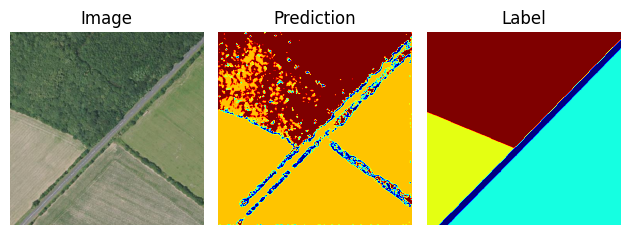

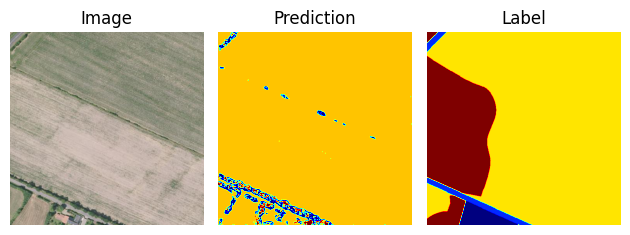

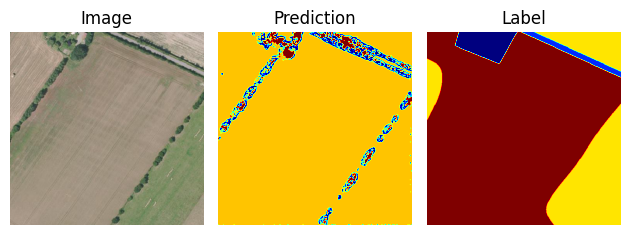

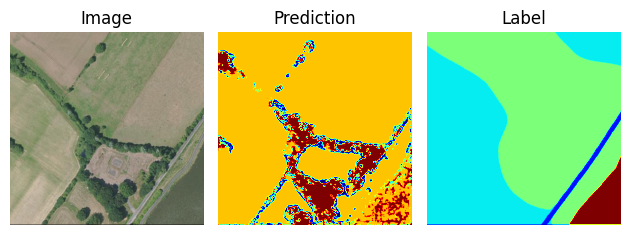

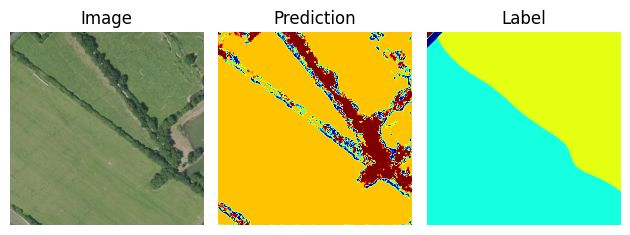

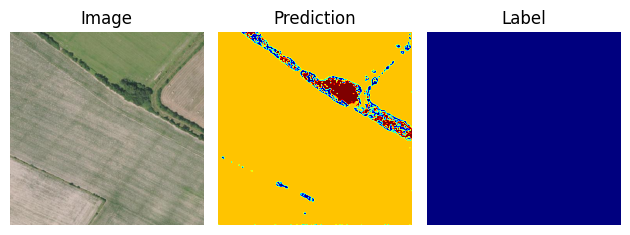

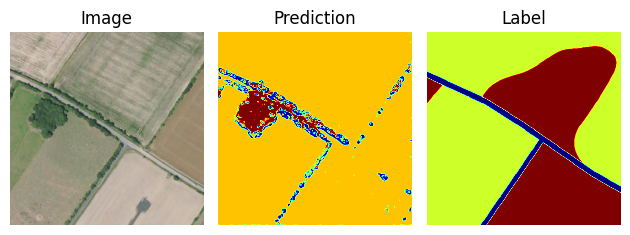

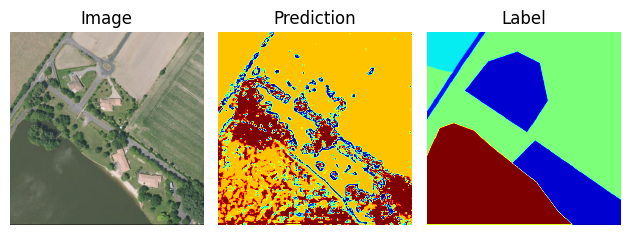

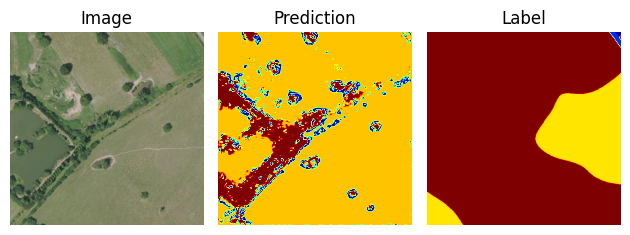

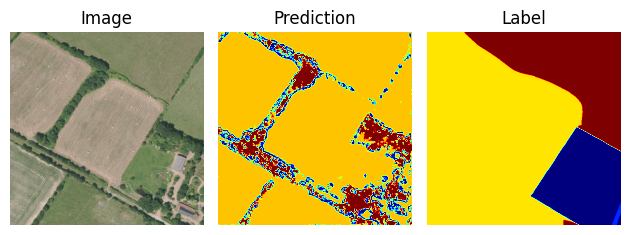

In [47]:
trained_model: SegNet = torch.load('/GEM/models/model.pth')
for i in range(100, 110):
    image = dataset[i]['image'].float().to(device).unsqueeze(0) 
    label = dataset[i]['landcover_map']
    pred = model(image)
    import matplotlib.pyplot as plt

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().cpu().int().numpy().transpose(1, 2, 0))
    plt.title('Image')
    plt.axis('off')

    # Plot the prediction
    plt.subplot(1, 3, 2)
    pred_img = pred.squeeze().argmax(dim=0).cpu().numpy()
    plt.imshow(pred_img, cmap='jet')
    plt.title('Prediction')
    plt.axis('off')

    # Plot the label
    plt.subplot(1, 3, 3)
    plt.imshow(label.squeeze().cpu().numpy(), cmap='jet')
    plt.title('Label')
    plt.axis('off')


    plt.tight_layout()
    plt.show()


In [38]:
import rasterio
import numpy as np

label = rasterio.open(dataset.file_df.iloc[0]['lc_path']).read()
print(np.unique(label))

[0]
